# Detect anomalies in time series via the Isolation Forest algorithm

See:

- {cite:p}`Bai2022Jan`
- {cite:p}`ContributorstoWikimediaprojects2022Oct`
- What is Isolation Forest? https://dsworld.org/what-is-an-isolation-forest/ 

# Programmatic preamble

In [3]:
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest# Generating data ----
rng = np.random.RandomState(42)

# Read data

We read-in some temperature time series stored in form of netCDF files.

In [6]:
path_to_data = Path('../data')  # where are the data?

t2m_some_location = xr.open_dataarray(path_to_data/'era5_and_land_2m_temperature_longitude_1643_latitude_4347.nc')
t2m_some_location_no_outliers = xr.open_dataarray(path_to_data/'era5_and_land_2m_temperature_longitude_2153_latitude_3947.nc')

# Example on a subset

We demonstrate the Isolation Forest algorithm on a subset of the temperature time series.

In [231]:
t2m_sample = t2m_some_location.sel(time=slice('2013-08-01', '2013-10-01'))
t2m_sample

<xarray.DataArray 't2m' (time: 1488)>
array([297.5435 , 296.61893, 295.6801 , ..., 288.37213, 288.27228, 288.141  ],
      dtype=float32)
Coordinates:
    lat      float64 ...
    lon      float64 ...
  * time     (time) datetime64[ns] 2013-08-01 ... 2013-10-01T23:00:00
Attributes:
    long_name:  2 metre temperature
    units:      K

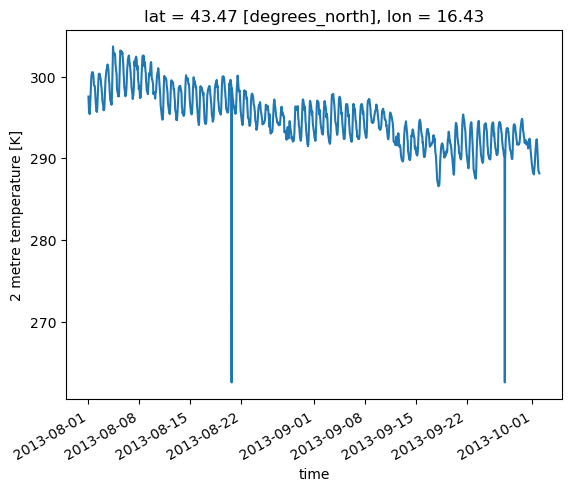

In [232]:
t2m_sample.plot()

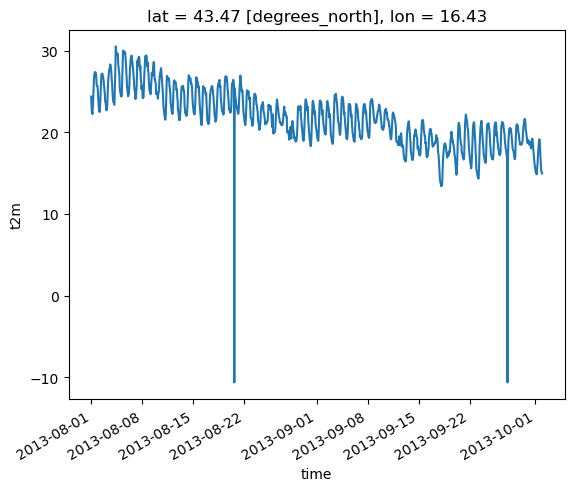

In [258]:
(t2m_sample - 273.15).plot()

## Contamination 0.01

First, we convert the `xarray` to `dataframe`

In [233]:
t2m = t2m_sample.to_dataframe()
df_t2m = t2m[['t2m']]
xdf = df_t2m.reset_index(drop=True)

Next, we initialize the Isolation Forest algorithm. The `contamination` parameter specifies the number of anomalies in our time series data, or else the percentage of points in our data to be anomalous.

In [234]:
model =  IsolationForest(
    n_estimators=1000,
    contamination=0.01,
    verbose=1,
)

In [235]:
model.get_params()

{'bootstrap': False,
 'contamination': 0.01,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 1000,
 'n_jobs': None,
 'random_state': None,
 'verbose': 1,
 'warm_start': False}

We then fit the _Isolation Forest_ model to the temperature time series. Temperature values will train the Isolation Forest model to identify anomalies.

In [236]:
%%time
model.fit(xdf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
/home/nik/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


CPU times: user 1.37 s, sys: 11 ms, total: 1.39 s
Wall time: 1.38 s


IsolationForest(contamination=0.01, n_estimators=1000, verbose=1)

Finally, we can use the trained Isolation Forest model to (make predictions!) identify anomalies in the time series.

In [237]:
%%time
xdf['outliers']=pd.Series(model.predict(xdf)).apply(lambda x: 'yes' if (x == -1) else 'no' )

CPU times: user 535 ms, sys: 0 ns, total: 535 ms
Wall time: 533 ms


Are there any outliers detected?

In [238]:
xdf.query('outliers=="yes"')

t2m outliers
81    303.684326      yes
82    303.273438      yes
105   303.179260      yes
106   303.159271      yes
472   262.544586      yes
1150  287.376251      yes
1151  287.145111      yes
1152  286.948212      yes
1153  286.839783      yes
1154  286.565826      yes
1155  286.605774      yes
1156  286.622925      yes
1157  286.677124      yes
1158  287.347717      yes
1373  262.544586      yes

Let's plot the results...

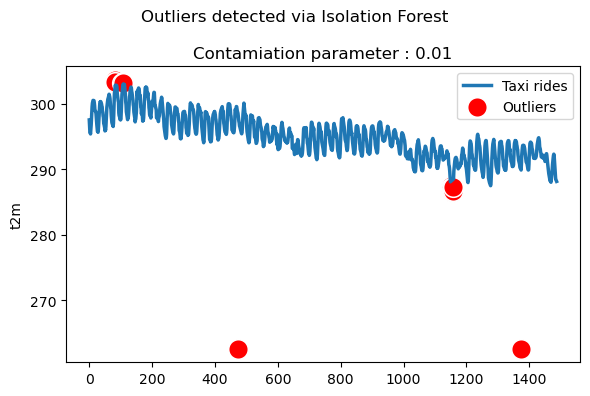

In [239]:
df_in = xdf.where(xdf['outliers']=='no')
df_out = xdf.where(xdf['outliers']=='yes')

fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df_in,
    # x='timestamp',
    x=xdf.index,
    y='t2m',
    ax=ax,
    linewidth=2.5,
    label='Taxi rides',
)
sns.scatterplot(
    data=df_out,
    # x='timestamp',
    x=xdf.index,
    y='t2m',
    # hue='outliers',
    ax=ax,
    color="red",
    s=200,
    label='Outliers',
)
plt.suptitle('Outliers detected via Isolation Forest')
contamination = model.get_params()['contamination']
plt.title(f'Contamiation parameter : {contamination}')
plt.tight_layout()
plt.show()

This is more than what we are after. Further examples using smaller contamination percentages.

## Contamination 0.005

In [240]:
t2m = t2m_sample.to_dataframe()
df_t2m = t2m[['t2m']]
xdf = df_t2m.reset_index(drop=True)

In [241]:
model =  IsolationForest(contamination=0.005)
model.get_params()

{'bootstrap': False,
 'contamination': 0.005,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [242]:
%%time
model.fit(xdf)

CPU times: user 158 ms, sys: 3.95 ms, total: 162 ms
Wall time: 161 ms


/home/nik/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.005)

In [243]:
%%time
xdf['outliers']=pd.Series(model.predict(xdf)).apply(lambda x: 'yes' if (x == -1) else 'no' )

CPU times: user 68.3 ms, sys: 4 ms, total: 72.3 ms
Wall time: 70.4 ms


In [244]:
xdf.query('outliers=="yes"')

t2m outliers
472   262.544586      yes
1152  286.948212      yes
1153  286.839783      yes
1154  286.565826      yes
1155  286.605774      yes
1156  286.622925      yes
1157  286.677124      yes
1373  262.544586      yes

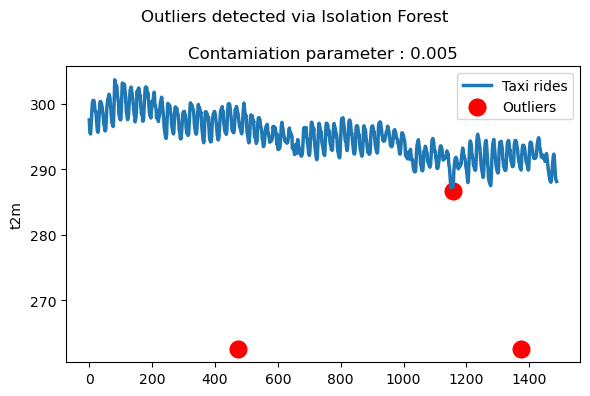

In [245]:
df_in = xdf.where(xdf['outliers']=='no')
df_out = xdf.where(xdf['outliers']=='yes')

fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df_in,
    # x='timestamp',
    x=xdf.index,
    y='t2m',
    ax=ax,
    linewidth=2.5,
    label='Taxi rides',
)
sns.scatterplot(
    data=df_out,
    # x='timestamp',
    x=xdf.index,
    y='t2m',
    # hue='outliers',
    ax=ax,
    color="red",
    s=200,
    label='Outliers',
)
plt.suptitle('Outliers detected via Isolation Forest')
contamination = model.get_params()['contamination']
plt.title(f'Contamiation parameter : {contamination}')
plt.tight_layout()
plt.show()

## Contamination 0.002

In [246]:
t2m = t2m_sample.to_dataframe()
df_t2m = t2m[['t2m']]
xdf = df_t2m.reset_index(drop=True)

In [247]:
%%time
model =  IsolationForest(contamination=0.002)
model.fit(xdf)
xdf['outliers']=pd.Series(model.predict(xdf)).apply(lambda x: 'yes' if (x == -1) else 'no' )

CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 222 ms


/home/nik/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [248]:
xdf.query('outliers=="yes"')

t2m outliers
81    303.684326      yes
472   262.544586      yes
1373  262.544586      yes

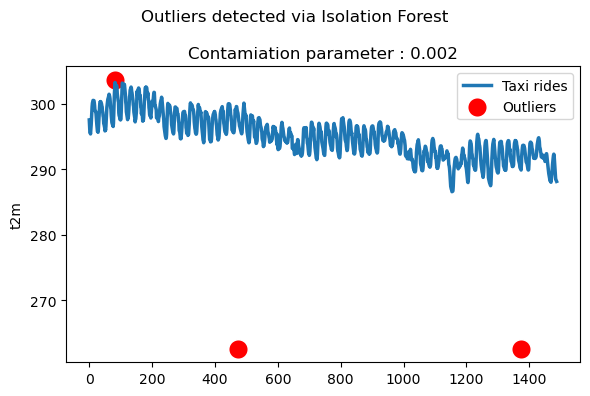

In [249]:
df_in = xdf.where(xdf['outliers']=='no')
df_out = xdf.where(xdf['outliers']=='yes')

fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df_in,
    # x='timestamp',
    x=xdf.index,
    y='t2m',
    ax=ax,
    linewidth=2.5,
    label='Taxi rides',
)
sns.scatterplot(
    data=df_out,
    # x='timestamp',
    x=xdf.index,
    y='t2m',
    # hue='outliers',
    ax=ax,
    color="red",
    s=200,
    label='Outliers',
)
plt.suptitle('Outliers detected via Isolation Forest')
contamination = model.get_params()['contamination']
plt.title(f'Contamiation parameter : {contamination}')
plt.tight_layout()
plt.show()

## Contamination 0.001

In [250]:
t2m = t2m_sample.to_dataframe()
df_t2m = t2m[['t2m']]
xdf = df_t2m.reset_index(drop=True)

In [251]:
%%time
model =  IsolationForest(contamination=0.001)
model.fit(xdf)
xdf['outliers']=pd.Series(model.predict(xdf)).apply(lambda x: 'yes' if (x == -1) else 'no' )

CPU times: user 225 ms, sys: 3.72 ms, total: 229 ms
Wall time: 226 ms


/home/nik/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [252]:
xdf.query('outliers=="yes"')

t2m outliers
472   262.544586      yes
1373  262.544586      yes

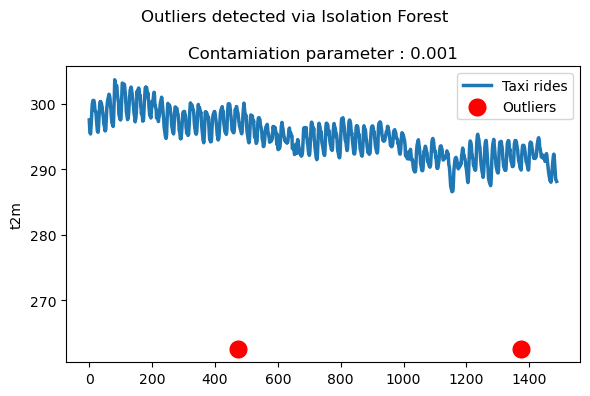

In [253]:
df_in = xdf.where(xdf['outliers']=='no')
df_out = xdf.where(xdf['outliers']=='yes')

fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df_in,
    # x='timestamp',
    x=xdf.index,
    y='t2m',
    ax=ax,
    linewidth=2.5,
    label='Taxi rides',
)
sns.scatterplot(
    data=df_out,
    # x='timestamp',
    x=xdf.index,
    y='t2m',
    # hue='outliers',
    ax=ax,
    color="red",
    s=200,
    label='Outliers',
)
plt.suptitle('Outliers detected via Isolation Forest')
contamination = model.get_params()['contamination']
plt.title(f'Contamiation parameter : {contamination}')
plt.tight_layout()
plt.show()

# Example on the full time series

<AxesSubplot: >

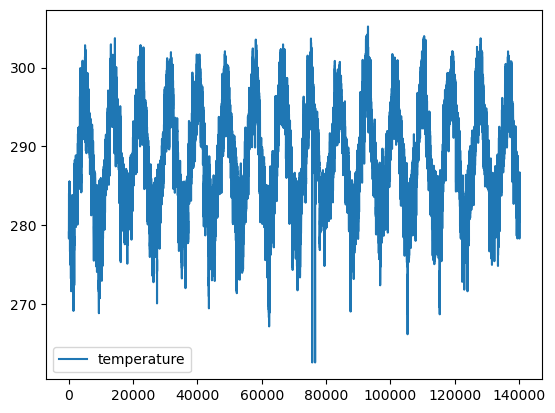

In [254]:
t2m = t2m_some_location.to_dataframe(name='temperature').reset_index()[['temperature']]
t2m.plot()

- Convert `xarray` input dataset(s) to a `dataframe`
- Set up the model and its parameters
- Train the model
- Detect outliers

# Contamination 0.001

In [255]:
%%time
model = IsolationForest(contamination=0.001)
model.fit(t2m)
t2m['outliers']=pd.Series(model.predict(t2m)).apply(lambda x: 'yes' if (x == -1) else 'no' )

/home/nik/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


CPU times: user 4.14 s, sys: 83.2 ms, total: 4.22 s
Wall time: 4.22 s


In [256]:
# t2m.query('outliers=="yes"')

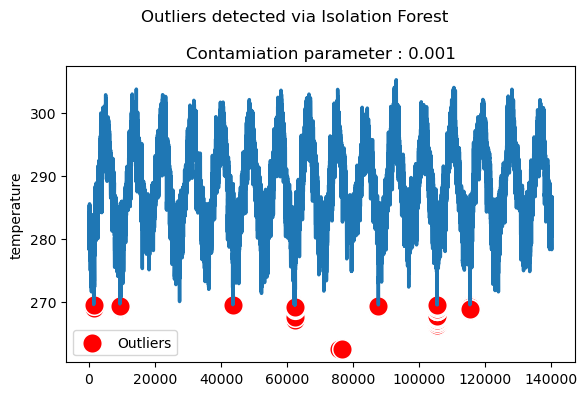

In [257]:
df_in = t2m.where(t2m['outliers']=='no')
df_out = t2m.where(t2m['outliers']=='yes')

fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df_in,
    # x='timestamp',
    x=t2m.index,
    y='temperature',
    ax=ax,
    linewidth=2.5,
)
sns.scatterplot(
    data=df_out,
    # x='timestamp',
    x=t2m.index,
    y='temperature',
    # hue='outliers',
    ax=ax,
    color="red",
    s=200,
    label='Outliers',
)
plt.suptitle('Outliers detected via Isolation Forest')
contamination = model.get_params()['contamination']
plt.title(f'Contamiation parameter : {contamination}')
plt.tight_layout()
plt.show()

## Contamination 0.0005

In [173]:
%%time
t2m = t2m_some_location.to_dataframe(name='temperature').reset_index()[['temperature']]
model = IsolationForest(contamination=0.0005)
model.fit(t2m)
t2m['outliers']=pd.Series(model.predict(t2m)).apply(lambda x: 'yes' if (x == -1) else 'no' )

/home/nik/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


CPU times: user 3.92 s, sys: 33.1 ms, total: 3.95 s
Wall time: 3.95 s


In [174]:
t2m.query('outliers=="yes"')

temperature outliers
62209    268.594116      yes
62210    268.374390      yes
62211    268.482849      yes
62212    268.391541      yes
62213    268.331604      yes
62214    268.260254      yes
62215    268.340149      yes
62278    268.645508      yes
62279    268.300201      yes
62280    268.174652      yes
62281    268.148987      yes
62282    267.652466      yes
62283    267.683838      yes
62284    267.623932      yes
62285    267.441284      yes
62286    267.124542      yes
62287    267.632477      yes
75688    262.544586      yes
76589    262.544586      yes
105333   268.437195      yes
105334   268.071930      yes
105335   267.592529      yes
105336   267.173065      yes
105337   266.844910      yes
105338   266.448242      yes
105339   266.376923      yes
105340   266.251343      yes
105341   266.168610      yes
105342   266.128662      yes
105343   266.177155      yes
105344   266.331268      yes
105345   266.630890      yes
105346   266.936218      yes
105347   267.352844      yes
105348   267.758026      yes
105349   268.029114      yes
105350   268.111877      yes
105351   268.029114      yes
105352   267.720947      yes
105353   267.606812      yes
105354   267.415619      yes
105355   267.190186      yes
105356   266.959045      yes
105357   266.919098      yes
105358   267.404205      yes
105359   267.235840      yes
105360   267.252960      yes
105361   267.272919      yes
105362   267.161652      yes
105363   267.358551      yes
105364   267.381378      yes
105365   267.478394      yes
105366   267.641052      yes
105367   267.789429      yes
105415   268.639771      yes

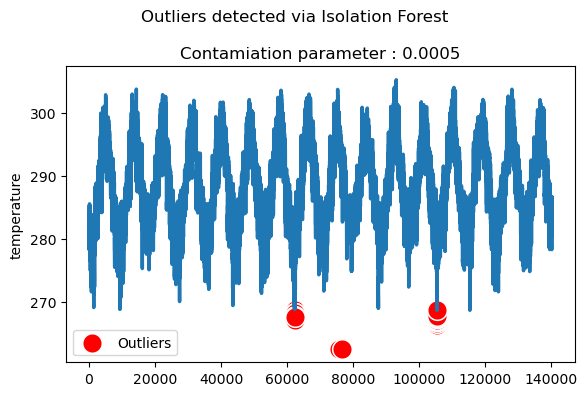

In [175]:
df_in = t2m.where(t2m['outliers']=='no')
df_out = t2m.where(t2m['outliers']=='yes')

fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df_in,
    # x='timestamp',
    x=t2m.index,
    y='temperature',
    ax=ax,
    linewidth=2.5,
)
sns.scatterplot(
    data=df_out,
    # x='timestamp',
    x=t2m.index,
    y='temperature',
    # hue='outliers',
    ax=ax,
    color="red",
    s=200,
    label='Outliers',
)
plt.suptitle('Outliers detected via Isolation Forest')
contamination = model.get_params()['contamination']
plt.title(f'Contamiation parameter : {contamination}')
plt.tight_layout()
plt.show()

## Contamination 0.0001

In [194]:
%%time
t2m = t2m_some_location.to_dataframe(name='temperature').reset_index()[['temperature']]
model = IsolationForest(contamination=0.0003)
model.fit(t2m)
t2m['outliers']=pd.Series(model.predict(t2m)).apply(lambda x: 'yes' if (x == -1) else 'no' )

/home/nik/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


CPU times: user 4.04 s, sys: 41.7 ms, total: 4.08 s
Wall time: 4.08 s


In [195]:
len(t2m.query('outliers=="yes"'))

8

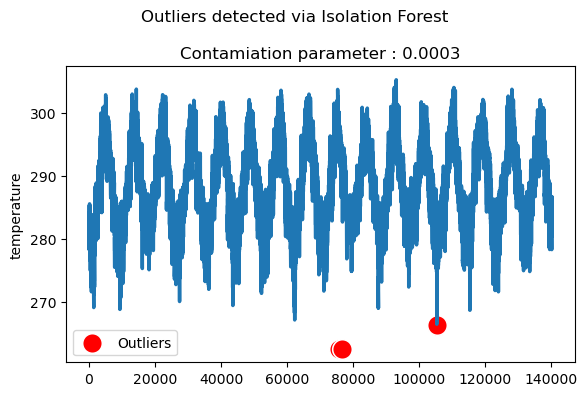

In [196]:
df_in = t2m.where(t2m['outliers']=='no')
df_out = t2m.where(t2m['outliers']=='yes')

fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df_in,
    # x='timestamp',
    x=t2m.index,
    y='temperature',
    ax=ax,
    linewidth=2.5,
)
sns.scatterplot(
    data=df_out,
    # x='timestamp',
    x=t2m.index,
    y='temperature',
    # hue='outliers',
    ax=ax,
    color="red",
    s=200,
    label='Outliers',
)
plt.suptitle('Outliers detected via Isolation Forest')
contamination = model.get_params()['contamination']
plt.title(f'Contamiation parameter : {contamination}')
plt.tight_layout()
plt.show()

In [210]:
%%time
t2m = t2m_some_location.to_dataframe(name='temperature').reset_index()[['temperature']]
model = IsolationForest(
    contamination=0.00028,
    bootstrap=True,
)
model.fit(t2m)
t2m['outliers']=pd.Series(model.predict(t2m)).apply(lambda x: 'yes' if (x == -1) else 'no' )

/home/nik/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


CPU times: user 4.09 s, sys: 41.9 ms, total: 4.14 s
Wall time: 4.14 s


In [211]:
len(t2m.query('outliers=="yes"'))

14

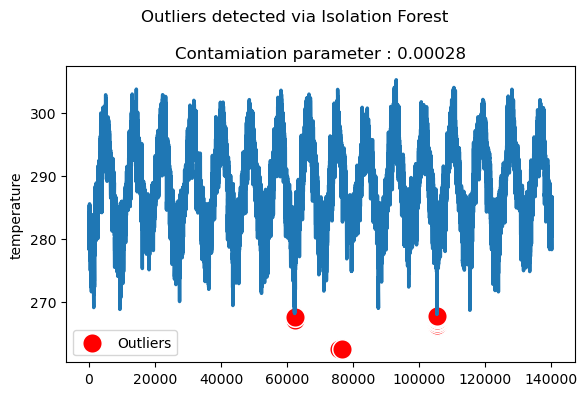

In [199]:
df_in = t2m.where(t2m['outliers']=='no')
df_out = t2m.where(t2m['outliers']=='yes')

fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df_in,
    # x='timestamp',
    x=t2m.index,
    y='temperature',
    ax=ax,
    linewidth=2.5,
)
sns.scatterplot(
    data=df_out,
    # x='timestamp',
    x=t2m.index,
    y='temperature',
    # hue='outliers',
    ax=ax,
    color="red",
    s=200,
    label='Outliers',
)
plt.suptitle('Outliers detected via Isolation Forest')
contamination = model.get_params()['contamination']
plt.title(f'Contamiation parameter : {contamination}')
plt.tight_layout()
plt.show()